### Plate Affine Transformation & Segmentation

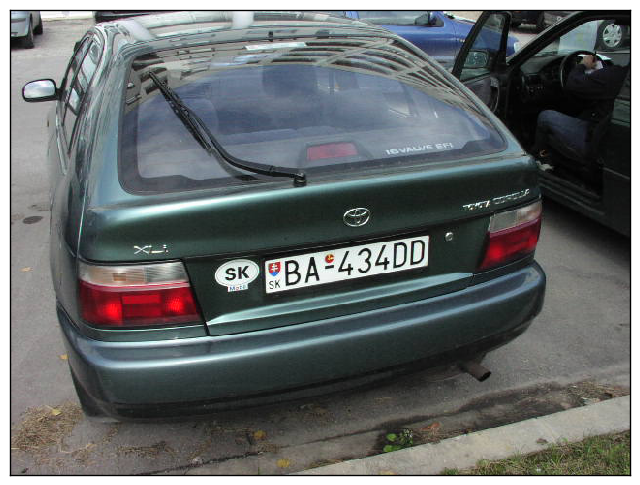

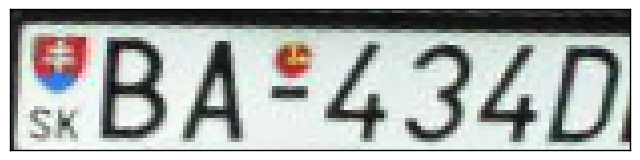

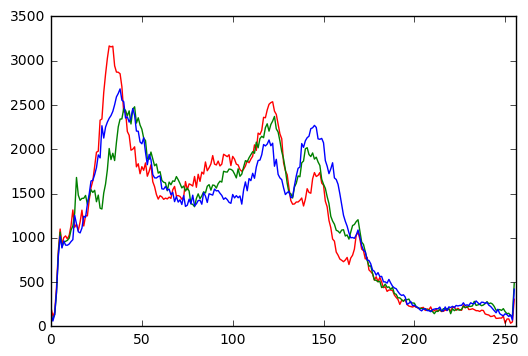

In [1]:
% matplotlib inline

import cv2
import matplotlib.pyplot as plt
from plate import detect, segment
import numpy as np

def draw_histogram(mat, channels=('r', 'g', 'b'), figsize=(8, 8), mask=None):
    for i, col in enumerate(channels):
        histr = cv2.calcHist([img], [i], mask, [256], [0, 256])
        plt.plot(histr, color=col)
        plt.xlim([0, 256])
    plt.show()

img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\070603\\P6070049.jpg"
# img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\141002\\Pa140022.jpg"
img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\141002\\Pa140015.jpg"

coordinates = detect.get_plates_coordinates(img_path) 

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plates = segment.segment_plates(img, coordinates)

plt.figure(figsize=(8, 8))
plt.imshow(img, interpolation='none')
plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(plates[0], interpolation='none')
plt.xticks([]), plt.yticks([])
plt.show()

draw_histogram(plates[0])

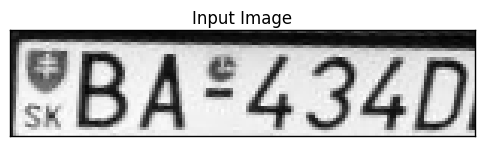

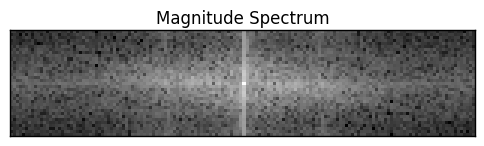

In [5]:
gray = cv2.cvtColor(plates[0], cv2.COLOR_RGB2GRAY)

# using opencv
dft = cv2.dft(np.float32(gray),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = np.log(1+cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))  # 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))

# using numpy
# f = np.fft.fft2(gray)
# fshift = np.fft.fftshift(f)
# magnitude_spectrum = np.log(1+np.abs(fshift))  # 20*np.log(np.abs(fshift))
## print(magnitude_spectrum.shape)

plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.imshow(gray, cmap = 'gray', interpolation='none')
plt.show()

plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.imshow(magnitude_spectrum, cmap = 'gray', interpolation='none')
plt.show()

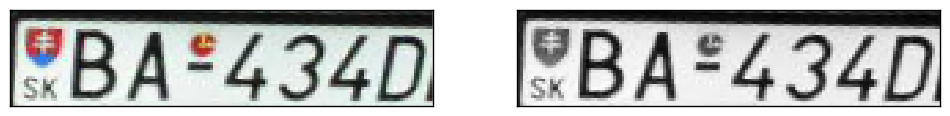

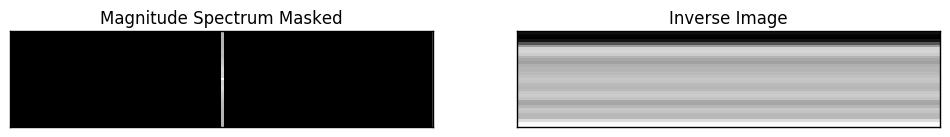

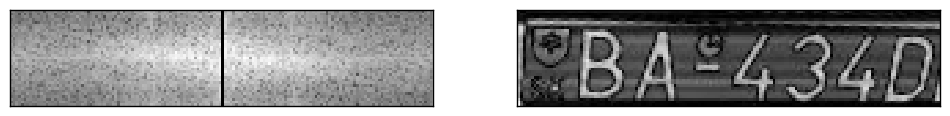

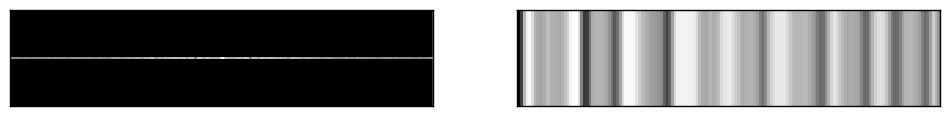

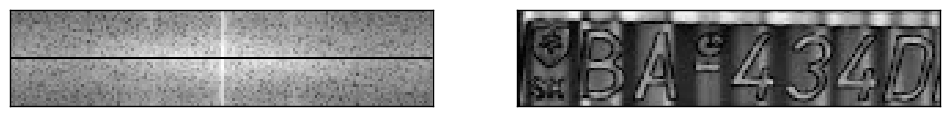

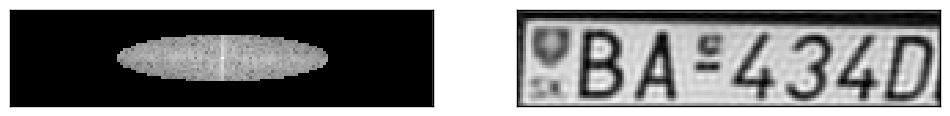

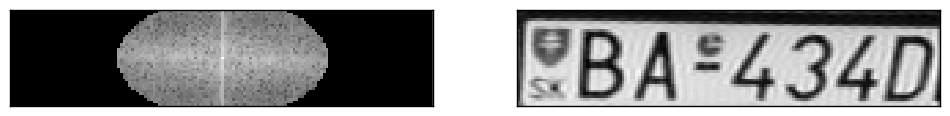

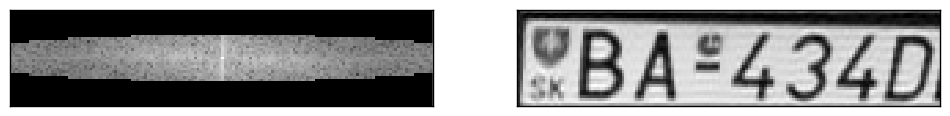

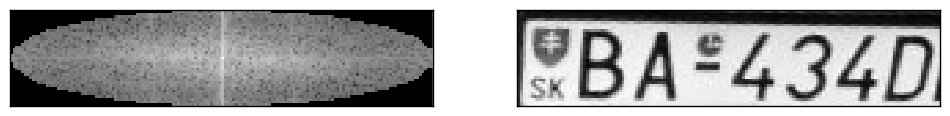

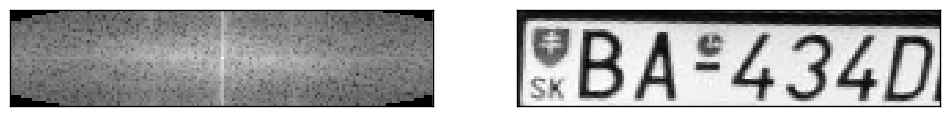

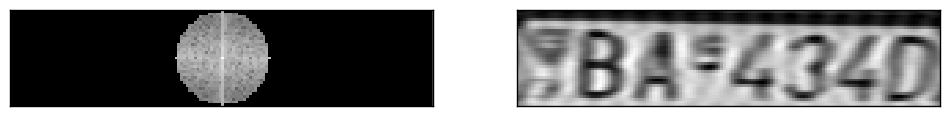

In [35]:
def calc_ifft(gray, mask):
    h, w = gray.shape

    # fourier using opencv
    dft = cv2.dft(np.float32(gray), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    
    # convert to mask3d only when using opencv 
    mask[mask==255] = 1
    mask3d =  np.zeros((h, w, 2), np.uint8)
    mask3d[:,:,0] = mask[:,:]
    mask3d[:,:,1] = mask[:,:]

    # "mask" the fourier
    dft_shift_masked = dft_shift*mask3d
    magnitude_spectrum_masked = np.log(1+cv2.magnitude(dft_shift_masked[:,:,0],dft_shift_masked[:,:,1]))
    # inverse & reconstruct
    f_ishift = np.fft.ifftshift(dft_shift_masked)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])
    
    return magnitude_spectrum_masked, img_back

def draw_comparison(imgs, titles=None, figsize=(12, 12), cmaps=['gray', 'gray'], interpolations=['none', 'none']):
    fig = plt.figure(figsize=figsize)
    a = fig.add_subplot(1, 2, 1)
    if titles:
        a.set_title(titles[0])
    plt.xticks([]), plt.yticks([])
    plt.imshow(imgs[0], cmap = cmaps[0], interpolation=interpolations[0])

    a = fig.add_subplot(1, 2, 2)
    if titles:
        a.set_title(titles[1])
    plt.xticks([]), plt.yticks([])
    plt.imshow(imgs[1], cmap =  cmaps[1], interpolation=interpolations[1])
    plt.show()


gray = cv2.cvtColor(plates[0], cv2.COLOR_RGB2GRAY)
h, w = gray.shape
draw_comparison([plates[0], gray])

mask = np.zeros((h, w),np.uint8)
cv2.line(mask, (w>>1, 0), (w>>1, h), 255, 1)
magnitude_spectrum_masked, img_back = calc_ifft(gray, mask)
draw_comparison([magnitude_spectrum_masked, img_back],
                ['Magnitude Spectrum Masked', 'Inverse Image'])

mask = np.zeros((h, w),np.uint8)
cv2.line(mask, (w>>1, 0), (w>>1, h), 255, 1)
mask = cv2.bitwise_not(mask)
magnitude_spectrum_masked, img_back = calc_ifft(gray, mask)
draw_comparison([magnitude_spectrum_masked, img_back])

# mask = np.zeros((h, w),np.uint8)
# cv2.line(mask, (w>>1, 0), (w>>1, h), 255, 5)
# mask = cv2.bitwise_not(mask)
# magnitude_spectrum_masked, img_back = calc_ifft(gray, mask)
# draw_comparison([magnitude_spectrum_masked, img_back])

# mask = np.zeros((h, w),np.uint8)
# cv2.line(mask, (w>>1, 0), (w>>1, h), 255, 10)
# mask = cv2.bitwise_not(mask)
# magnitude_spectrum_masked, img_back = calc_ifft(gray, mask)
# draw_comparison([magnitude_spectrum_masked, img_back])

mask = np.zeros((h, w),np.uint8)
cv2.line(mask, (0, h>>1), (w, h>>1), 255, 1)
magnitude_spectrum_masked, img_back = calc_ifft(gray, mask)
draw_comparison([magnitude_spectrum_masked, img_back])

mask = np.zeros((h, w),np.uint8)
cv2.line(mask, (0, h>>1), (w, h>>1), 255, 1)
mask = cv2.bitwise_not(mask)
magnitude_spectrum_masked, img_back = calc_ifft(gray, mask)
draw_comparison([magnitude_spectrum_masked, img_back])

mask = np.zeros((h, w),np.uint8)
cv2.ellipse(mask, center=(w>>1, h>>1), axes=(w>>2, h>>2), angle=0, startAngle=0, endAngle=360, color=255, thickness=-1)
magnitude_spectrum_masked, img_back = calc_ifft(gray, mask)
draw_comparison([magnitude_spectrum_masked, img_back])

mask = np.zeros((h, w),np.uint8)
cv2.ellipse(mask, center=(w>>1, h>>1), axes=(w>>2, (h>>2)+h>>1), angle=0, startAngle=0, endAngle=360, color=255, thickness=-1)
magnitude_spectrum_masked, img_back = calc_ifft(gray, mask)
draw_comparison([magnitude_spectrum_masked, img_back])

mask = np.zeros((h, w),np.uint8)
cv2.ellipse(mask, center=(w>>1, h>>1), axes=((w>>2)+w>>1, (h>>2)), angle=0, startAngle=0, endAngle=360, color=255, thickness=-1)
magnitude_spectrum_masked, img_back = calc_ifft(gray, mask)
draw_comparison([magnitude_spectrum_masked, img_back])

mask = np.zeros((h, w),np.uint8)
cv2.ellipse(mask, center=(w>>1, h>>1), axes=(w>>1, h>>1), angle=0, startAngle=0, endAngle=360, color=255, thickness=-1)
magnitude_spectrum_masked, img_back = calc_ifft(gray, mask)
draw_comparison([magnitude_spectrum_masked, img_back])

mask = np.zeros((h, w),np.uint8)
cv2.ellipse(mask, center=(w>>1, h>>1), axes=((w>>2)+w>>1, (h>>2)+h>>1), angle=0, startAngle=0, endAngle=360, color=255, thickness=-1)
magnitude_spectrum_masked, img_back = calc_ifft(gray, mask)
draw_comparison([magnitude_spectrum_masked, img_back])

mask = np.zeros((h, w),np.uint8)
cv2.circle(mask, center=(w>>1, h>>1), radius=h>>1, color=255, thickness=-1)
magnitude_spectrum_masked, img_back = calc_ifft(gray, mask)
draw_comparison([magnitude_spectrum_masked, img_back])

# mask = np.zeros((h, w),np.uint8)
# cv2.line(mask, (w>>1, 0), (w>>1, h), 255, 2)
# cv2.line(mask, (w>>2, 0), (w>>2, h), 255, 2)
# cv2.line(mask, ((w>>1)+(w>>2), 0), ((w>>1)+(w>>2), h), 255, 2)
# mask = cv2.bitwise_not(mask)
# magnitude_spectrum_masked, img_back = calc_ifft(gray, mask)
# draw_comparison([magnitude_spectrum_masked, img_back])

In [ ]:
# f_ishift = np.fft.ifftshift(fshift_masked)
# img_back = cv2.idft(f_ishift)
# img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

# plt.title('Output Image'), plt.xticks([]), plt.yticks([])
# plt.imshow(img_back, cmap = 'gray', interpolation='none')
# plt.show()



# # create a mask first, center square is 1, remaining all zeros
# mask = np.zeros((rows,cols,2),np.uint8)
# mask[crow-10:crow+10, ccol-50:ccol+50] = 1

# # apply mask and inverse DFT
# fshift_mask = dft_shift*mask
# f_ishift = np.fft.ifftshift(fshift_mask)
# img_back = cv2.idft(f_ishift)
# img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

# plt.imshow(img_back, cmap = 'gray', interpolation='none')
# plt.title('Image Reconstructed'), plt.xticks([]), plt.yticks([])
# plt.show()

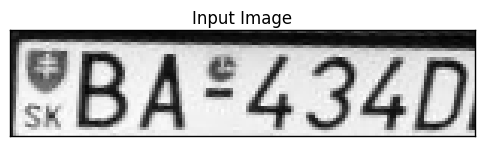

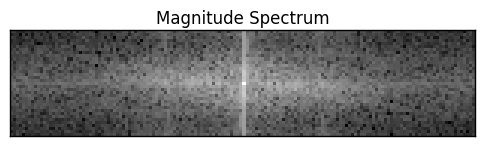

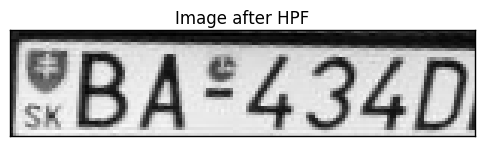

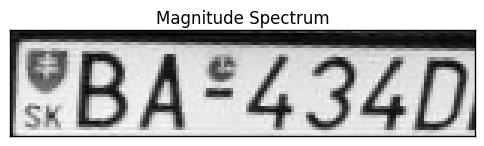

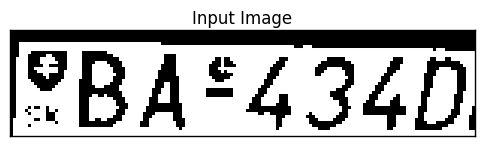

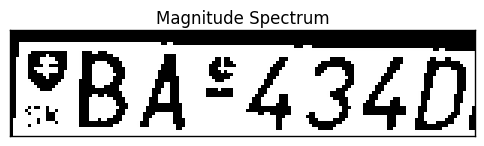

In [71]:
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.imshow(img, cmap = 'gray', interpolation='none')
plt.show()

plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.imshow(magnitude_spectrum, cmap = 'gray', interpolation='none')
plt.show()

rows, cols = img.shape
crow,ccol = int(rows/2) , int(cols/2)
# print(crow, ccol)
fshift[crow-20:crow+20, ccol-5:ccol+5] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
plt.imshow(img_back, cmap = 'gray', interpolation='none')
plt.show()

# http://docs.opencv.org/2.4.8/modules/core/doc/operations_on_arrays.html#normalize
img_back_gray = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
plt.imshow(img_back_gray, cmap = 'gray', interpolation='none')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

_, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
_, img_back_bin = cv2.threshold(img_back_gray, 0, 255, cv2.THRESH_OTSU)

plt.imshow(img_bin, cmap = 'gray', interpolation='none')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.show()

plt.imshow(img_back_bin, cmap = 'gray', interpolation='none')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

(35, 154)


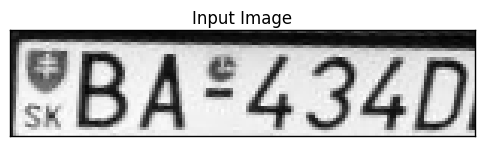

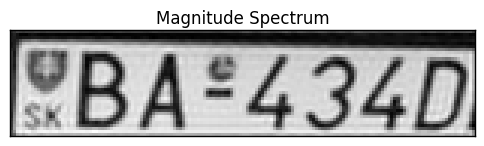

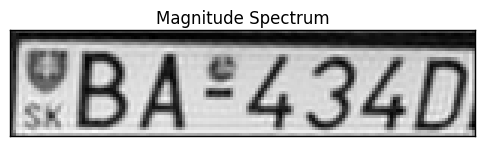

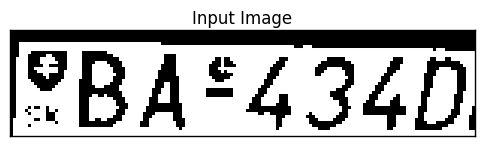

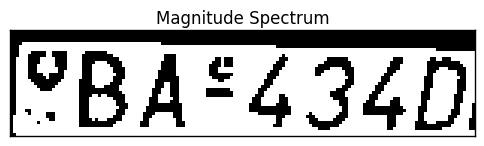

In [67]:
rows, cols = img.shape
crow,ccol = int(rows/2), int(cols/2)

print(img.shape)

# create a mask first, center square is 1, remaining all zeros
mask = np.zeros((rows,cols,2),np.uint8)
mask[crow-10:crow+10, ccol-50:ccol+50] = 1

# apply mask and inverse DFT
fshift = dft_shift*mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

plt.imshow(img, cmap = 'gray', interpolation='none')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.show()

plt.imshow(img_back, cmap = 'gray', interpolation='none')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

# http://docs.opencv.org/2.4.8/modules/core/doc/operations_on_arrays.html#normalize
img_back_gray = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
plt.imshow(img_back_gray, cmap = 'gray', interpolation='none')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

_, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
_, img_back_bin = cv2.threshold(img_back_gray, 0, 255, cv2.THRESH_OTSU)

plt.imshow(img_bin, cmap = 'gray', interpolation='none')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.show()

plt.imshow(img_back_bin, cmap = 'gray', interpolation='none')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()